In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import string

import spacy

import pickle
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer
warnings.simplefilter('ignore')
sns.set(style="white", palette="muted", color_codes=True)
# spacy_nlp = spacy.load('en_core_web_sm')
# shap.initjs()
# outputdir = 'Model_Ouput'
# if not os.path.exists(outputdir):
#     os.makedirs(outputdir)




In [2]:
dataset = pd.read_csv(r'C:\Users\Kavyasree P\Downloads\amazon_alexa.tsv',sep='\t') # reading dataset
dataset.dropna(inplace =True) # dropping null value is there are any
dataset.sample(5) # sample of 5 rows 

,rating,date,variation,verified_reviews,feedback
2074,1,5-Jul-18,Black Plus,Didn’t really work as smooth as they make it s...,0
901,4,29-Jul-18,Charcoal Fabric,We are still discovering all that the Echo can...,1
1125,5,29-Jul-18,Black Spot,Love it. Small with good sound,1
2686,5,30-Jul-18,Black Dot,"A great product for the price, works well!!",1
387,5,24-Jul-18,Black,It works great and sounds good!,1


In [3]:
print('Observations:',dataset.shape[0],'\n','Features:',dataset.shape[1])  # Displaying dimension of data

Observations: 3149 
 Features: 5


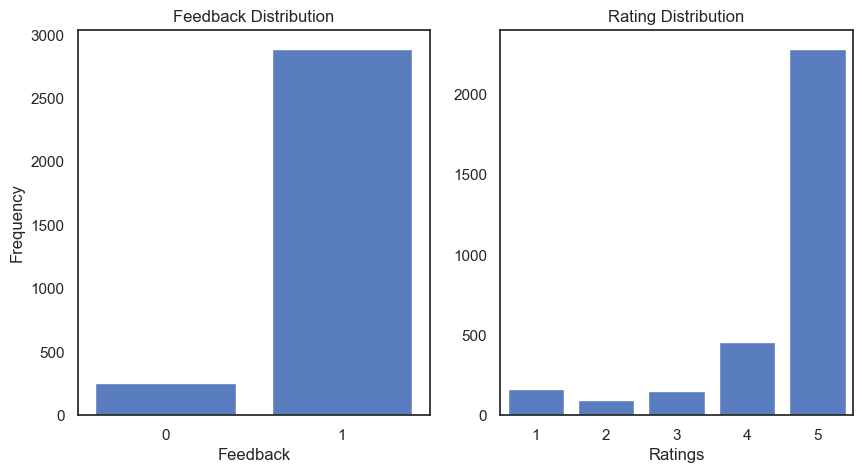

In [4]:
# Displaying distribution of the Feedback and Ratings
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # No need to share the y-axis
plt.subplots_adjust(hspace=0.5)
ax[0].set_title('Feedback Distribution')
ax[1].set_title('Rating Distribution')

# Update the countplot with explicit data parameter
sns.countplot(x='feedback', data=dataset, ax=ax[0])
sns.countplot(x='rating', data=dataset, ax=ax[1])

ax[0].set_xlabel('Feedback')
ax[1].set_xlabel('Ratings')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('')

plt.show()

* Its seems that positive class is more than the negative class, which indicate imbalance of class.
* Moreover there are more people has provided rating of 5 star to Alexa product which indicate that customer is satisfied with the product.

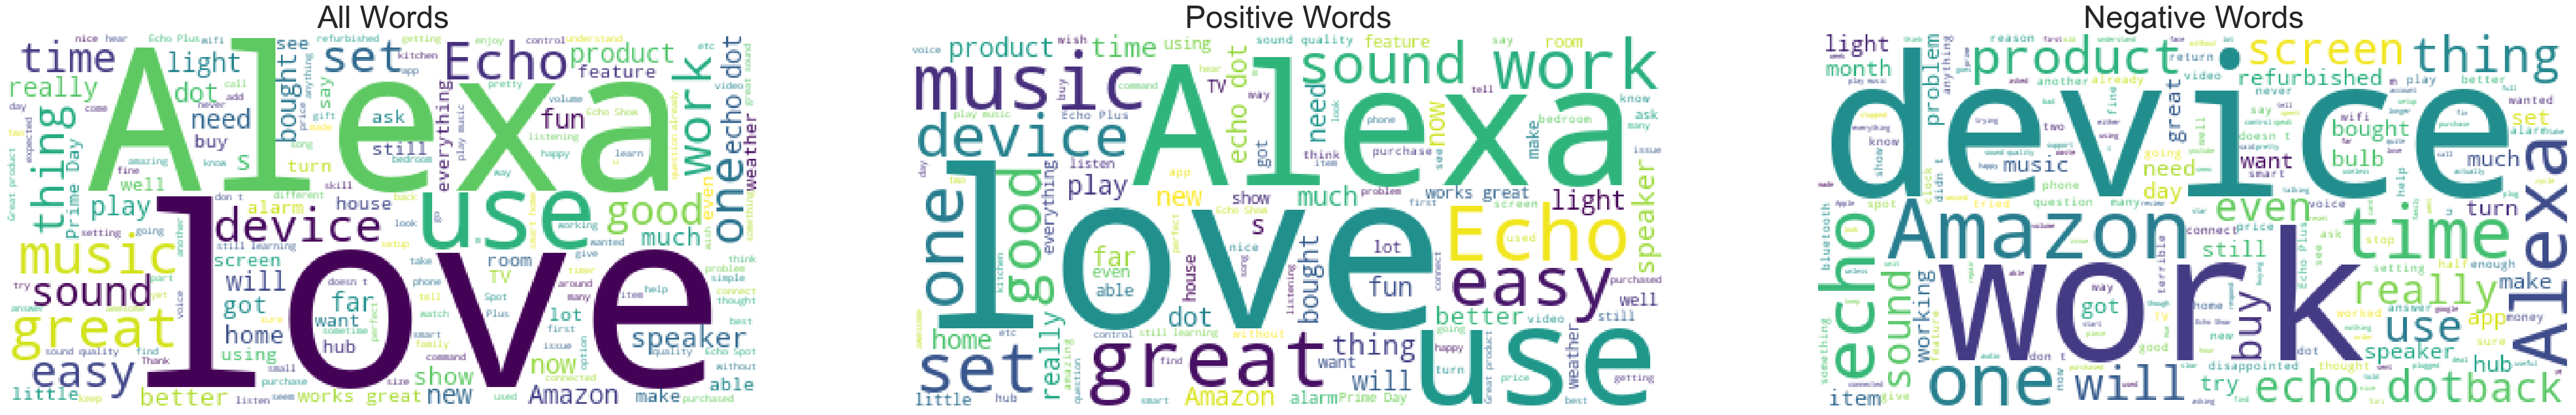

In [5]:
# Displaying word cloud
from wordcloud import WordCloud

All_word = ''.join(dataset['verified_reviews'].tolist()) # All words in the given corpus
positive_words = ''.join(dataset[dataset['feedback']==1]['verified_reviews'].tolist()) # All positive words
negative_words = ''.join(dataset[dataset['feedback']==0]['verified_reviews'].tolist()) # All negative words
category = ['All Words','Positive Words','Negative Words']
data_wordcloud = [All_word,positive_words,negative_words]

plt.figure(figsize=(80,80))
for i in range(0,3):
    t=i+1
    plt.subplot(5, 4, t).set_title(category[i],fontsize=40)
    plt.axis('off')
    plt.imshow(WordCloud(background_color='white').generate(data_wordcloud[i]))
#plt.savefig('Wordcloud.png')
plt.show()



#### Text Preprocessing

In [6]:
def text_cleaning(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))  # Use NLTK's stop words
    text = text.lower()
    # Lemmatize and remove stopwords and punctuation
    text = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words and word not in string.punctuation]
    return ' '.join(text)
dataset['verified_reviews_clean'] = dataset['verified_reviews'].apply(lambda x: text_cleaning(x))
reviews = dataset['verified_reviews_clean']
feedback = dataset['feedback']




In [7]:
# Termite will help us know, which words provide an import to category
category = list(feedback.unique())
vectorizer = TfidfVectorizer()
vectorizer.fit(dataset['verified_reviews_clean']) #Fitting TFIDF vectorizer on dataset

mat_tfidf_cat0 = vectorizer.transform(dataset[feedback==category[0]]['verified_reviews_clean']) # creating a matrix
category0_score = mat_tfidf_cat0.sum(axis=0) # taking sum of the matrix for all rows
category0_words_frequency = [(word, category0_score[0, idx]) for word, idx in vectorizer.vocabulary_.items()] # form a list all tuple with (words, score) 
df_cat0 = pd.DataFrame(list(sorted(category0_words_frequency, key = lambda x: x[1], reverse=True)),columns=['feature','Positive']) #Sort and form a dataframe
df_cat0 = df_cat0.head(10) # take top 10 row

mat_tfidf_cat1 = vectorizer.transform(dataset[feedback==category[1]]['verified_reviews_clean'])
category0_score = mat_tfidf_cat1.sum(axis=0)
category0_words_frequency = [(word, category0_score[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
df_cat1 = pd.DataFrame(list(sorted(category0_words_frequency, key = lambda x: x[1], reverse=True)),columns=['feature','Negative'])
df_cat1 = df_cat1.head(10)

df_categories = pd.merge(df_cat0,df_cat1,how='outer') #join two dataframes
df_categories.fillna(0,inplace=True) #Fill all nan with 0
df_categories.set_index('feature',inplace=True) # set all words as index
df_categories_norm = (df_categories)/(df_categories.max()-df_categories.min()) # standard normalization

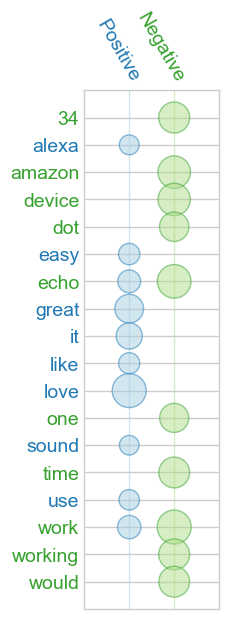

In [10]:
import numpy as np
from textacy.viz.termite import draw_termite_plot
draw_termite_plot(np.array(df_categories_norm.values),df_categories_norm.columns,df_categories_norm.index,highlight_cols=[0,1])
plt.show()

In [11]:
xtrain,xtest,ytrain,ytest = train_test_split(reviews,feedback,test_size=0.2,random_state=45) #splitting dataset with test size as 20%

In [12]:
#Creating dataset for Bag of word model
countvect = CountVectorizer()
review_train_vectorize = countvect.fit_transform(xtrain)
review_test_vectorize = countvect.transform(xtest)

#Creating dataset for TFIDF model
tfidf_transform = TfidfTransformer()
review_train_tfidf = tfidf_transform.fit_transform(review_train_vectorize)
review_test_tfidf = tfidf_transform.transform(review_test_vectorize)

#### Naive Bayes

In [13]:
#Bow model
nb = MultinomialNB()
nb.fit(review_train_vectorize,ytrain)
y_pred_vect = nb.predict(review_test_vectorize)
print(classification_report(ytest,y_pred_vect))
print(f'Accuracy Score:{accuracy_score(ytest,y_pred_vect)}')
print(f'AUCROC Score:{roc_auc_score(ytest,y_pred_vect)}')


              precision    recall  f1-score   support

           0       0.90      0.32      0.47        57
           1       0.94      1.00      0.97       573

    accuracy                           0.93       630
   macro avg       0.92      0.66      0.72       630
weighted avg       0.93      0.93      0.92       630

Accuracy Score:0.9349206349206349
AUCROC Score:0.656149536144025


In [14]:
#TFIDF model
nb.fit(review_train_tfidf,ytrain)
ypred_nb_tfidf = nb.predict(review_test_tfidf)
print(classification_report(ytest,ypred_nb_tfidf))
print(f'Accuracy Score:{accuracy_score(ytest,ypred_nb_tfidf)}')
print(f'AUCROC Score:{roc_auc_score(ytest,ypred_nb_tfidf)}')



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.91      1.00      0.95       573

    accuracy                           0.91       630
   macro avg       0.45      0.50      0.48       630
weighted avg       0.83      0.91      0.87       630

Accuracy Score:0.9095238095238095
AUCROC Score:0.5


SVM

In [15]:
#Bow model
svm = SVC(kernel='linear')
svm.fit(review_train_vectorize,ytrain)
ypred_vect_svm = svm.predict(review_test_vectorize)
print(classification_report(ytest,ypred_vect_svm))
print(f'Accuracy Score:{accuracy_score(ytest,ypred_vect_svm)}')
print(f'AUC ROC Score:{roc_auc_score(ytest,ypred_vect_svm)}')


              precision    recall  f1-score   support

           0       0.75      0.47      0.58        57
           1       0.95      0.98      0.97       573

    accuracy                           0.94       630
   macro avg       0.85      0.73      0.77       630
weighted avg       0.93      0.94      0.93       630

Accuracy Score:0.9380952380952381
AUC ROC Score:0.7289887021217967


In [16]:
#TFIDF model
svm.fit(review_train_tfidf,ytrain)
ypred_tfidf_svm = svm.predict(review_test_tfidf)
print(classification_report(ytest,ypred_tfidf_svm))
print(f'Accuracy Score:{accuracy_score(ytest,ypred_tfidf_svm)}')
print(f'AUC ROC Score:{roc_auc_score(ytest,ypred_tfidf_svm)}')


              precision    recall  f1-score   support

           0       0.85      0.19      0.31        57
           1       0.93      1.00      0.96       573

    accuracy                           0.92       630
   macro avg       0.89      0.59      0.64       630
weighted avg       0.92      0.92      0.90       630

Accuracy Score:0.9238095238095239
AUC ROC Score:0.5947460273720953
